In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
#                                   AnnotationBbox)
#import regionmask
import geopandas
import pandas as pd
import math
import warnings
import matplotlib.pyplot as plt
from matplotlib import cm as CM
from matplotlib.colors import LogNorm,PowerNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
#import maskout
from scipy import ndimage
#from scipy.ndimage import gaussian_filter

In [2]:
def plot_rec(bmap, lower_left, upper_left, lower_right, upper_right):
    xs = [lower_left[0], upper_left[0],
          upper_right[0],lower_right[0],lower_left[0]]
    ys = [lower_left[1], upper_left[1],
          upper_right[1],lower_right[1],lower_left[1]]
    bmap.plot(xs, ys, color="r",latlon = True)

In [3]:
def fill_maxwell(ax):
        Nlignes=300
        Ncol=300
        img = np.zeros((Nlignes,Ncol,4))
        dx = 2.0/(Ncol-1)
        dy = 1.0/(Nlignes-1)
        for i in range(Ncol-1):
            for j in range(Nlignes-1):
                x = -1.0+i*dx
                y = j*dy
                v = y
                r = (x+1-v)/2.0
                b = 1.0-v-r
                if (r>=0) and (r<=1.0) and (v>=0) and (v<=1.0) and (b>=0) and (b<=1.0):
                    r,v,b = 1/max(r,v,b)*r,1/max(r,v,b)*v,1/max(r,v,b)*b
                    img[j][i] = np.array([r,v,b,1.0])
                else:
                    img[j][i] = np.array([1.0,1.0,1.0,0.0])
        a = 1.0/math.sqrt(3)
        fig = ax.imshow(img,origin='lower',extent=[-a,a,0.0,1.0])
        # ax.plot([0,a/2.,-a/2.,0],[0,0.5,0.5,0],'w--',linewidth=2,)
        # ax.annotate("", xy=( a/2.,0.5), xytext=( -a ,0.),  arrowprops=dict(arrowstyle="->"))
        # ax.annotate("", xy=(-a/2.,0.5), xytext=( a,0.),   arrowprops=dict(arrowstyle="->"))
        # ax.annotate("", xy=( 0,1.),     xytext=( 0,0.),  color='white', arrowprops=dict(arrowstyle="->"))
        # ax.annotate("", xy=( a ,0.),    xytext=( -a/2.,0.5) ,color='white',arrowprops=dict(arrowstyle="->"))
        # ax.annotate("", xy=(-a,0.),     xytext=( a/2.,0.5) ,color='white',arrowprops=dict(arrowstyle="->"))
        # ax.annotate("", xy=( 0,0.),     xytext=( 0,1.),     arrowprops=dict(arrowstyle="->"))        
        # #         
        # ax.plot([0,a/2.],[1/3.,0.5],'w--',linewidth=2,)
        # ax.plot([0,-a/2.],[1/3.,0.5],'w--',linewidth=2,)
        # ax.plot([0,0.],[1/3.,0.],'w--',linewidth=2,)  
        fsize = 10      
        plt.text(-0.78, -0.15, "$\Delta{0-120}$", fontsize=fsize, color='k',weight='bold') #,rotation=30
        plt.text( 0.38, -0.15, "$\Delta{120-240}$", fontsize=fsize, color='k',weight='bold')  ## ,rotation=-30
        plt.text( -0.15,  1.05, "$\Delta{240-360}$", fontsize=fsize, color='k',weight='bold')

        # ax.text(  a/2.+0.05,0.6, "Tair\n-100%"   , fontsize=fsize, color='w',rotation=30)
        # ax.text( -a/2-0.3,0.6, "DF\n-100%"   , fontsize=fsize, color='w',rotation=-30)
        # ax.text( -0.1,  -0.2, " VPD\n-100%", fontsize=fsize, color='w')
                        
        ax.axis('off')
        return fig

def piefig(ax,fracs):
    labels = '$\Delta{DF}$', '$\Delta{Tair}$', '$\Delta{VPD}$'
    fsize = 10      
    # A standard pie plot
    wedges, texts, autotexts =ax.pie(fracs, labels=labels, autopct='%.0f%%',textprops=dict(color="k",fontsize=fsize, weight='bold')\
        , colors=['r','b','g'],shadow=True)
    plt.setp(autotexts, fontsize=fsize, weight='bold')
    plt.setp(texts, fontsize=fsize, weight='bold')
    # ax.set_title("Dominant factor",fontsize=5)
    return ax

In [4]:
def regfig(lat,lon,data,z_min=0.,z_max=1.5,figname="regcmfig",title=None,units=None):
    center_lon=(lon.min()+lons.max())/2
    proj = ccrs.PlateCarree(central_longitude=center_lon)
    fig = plt.figure(figsize=[11.8, 8])
    ax = fig.add_axes([0.1,0.1,0.85,0.85],projection=proj) 
    #ax.background_img(name='BM', resolution='high')
    #Zoom in
    #ax.set_extent([108, 132, 18, 50])
    #Add map features
    ax.add_feature(cfeature.LAND, facecolor='0.99') #Grayscale colors can be set using 0 (black) to 1 (white)
    ax.add_feature(cfeature.LAKES, alpha=0.9)  #Alpha sets transparency (0 is transparent, 1 is solid)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), zorder=10, linestyle=':') # high resolution
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), zorder=10, linestyle=':') # mediate resolution
    ax.add_feature(cfeature.RIVERS) # low resolution
    #ax.stock_img()

    #We can use additional features from Natural Earth (http://www.naturalearthdata.com/features/)
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces_lines',
            scale='50m',facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray', zorder=10)
    fname = 'D:\data\map\CHN_adm1.shp'
    adm1_shapes = list(Reader(fname).geometries())
    #ccrs.PlateCarree()
    ax.add_geometries(adm1_shapes, crs=ccrs.PlateCarree(),edgecolor='black', facecolor='none', alpha=0.5,linewidths=0.5)
    ax.scatter(lon,lat,s=20,color=data,transform=ccrs.PlateCarree())
    #Add lat/lon gridlines every 20° to the map
    #img_extent=(108, 132, 18, 50)
    #contour=ax.imshow(data,interpolation='nearest',transform=ccrs.PlateCarree())
    #img_gaus = ndimage.filters.gaussian_filter(data, 2, mode='nearest')
    #clip=maskout.shp2clip(contour,ax,'D:\software\MeteoInfo\map\country1',"China")
    if(title): fig.text(0.15, 0.9, title,fontsize="larger",color="black") #,weight='bold')
    # if(title): fig.text(0.8, 0.25, title,fontsize="large")
    # plt.show()
    left, bottom, width, height = 0.35, 0.15, 0.10, 0.10
    ax2 = fig.add_axes([left, bottom, width, height])
    fig2 = fill_maxwell(ax2)
    
    #left, bottom, width, height = 0.9, 0.38, 0.10, 0.10
    #ax3 = fig.add_axes([left, bottom, width, height])
    #fig3 = piefig(ax3,fracs)    
    # plt.savefig(figname, dpi=300)
    with PdfPages(figname+'use1.pdf') as pdf:
        pdf.savefig(fig,bbox_inches='tight',pad_inches = 0.05 )    

In [5]:
#meteo_file = "ccn_mrl-use.csv"
meteo_file = "wind_ccn.csv"

In [6]:
df= pd.read_csv(meteo_file)

In [7]:
# 获取每个变量的值
lons = df['lon_bin']
# pd.series to np.array
lons=np.array(lons)
lats = df['lat_bin']
lats=np.array(lats)
fa1 = df['ccn_120']
fa2 = df['ccn_240']
fa3 = df['ccn_360']

In [8]:
df

,lat_bin,lon_bin,ccn_120,ccn_240,ccn_360
0,10.5,125.0,300.000000,195.000000,401.000000
1,11.0,122.5,363.000000,518.000000,507.250000
2,11.0,124.5,2211.000000,552.000000,861.333333
3,11.0,125.0,216.000000,215.000000,1089.600000
4,11.5,119.5,462.000000,901.000000,450.000000
5,11.5,120.0,247.000000,321.000000,720.666667
6,11.5,124.5,1610.000000,702.833333,2226.750000
7,11.5,125.0,449.000000,394.750000,578.000000
8,11.5,126.5,240.000000,223.000000,559.000000
9,11.5,127.5,316.000000,139.000000,634.666667


In [9]:
cgpp = np.c_[abs(fa1),abs(fa2),abs(fa3)]   ### par: red; vpd: green; temp: blue
#cgpp  = abs(cgpp)/max((abs(fa1).max(),abs(fa2).max(),abs(fa3).max()))
cgpp  = cgpp * (1/np.max(cgpp,axis=1))[:,np.newaxis]

In [10]:
#[Python3实现常用数据标准化方法](https://blog.csdn.net/zzc15806/article/details/80712320)
def ZscoreNormalization(x):
    """Z-score normaliaztion"""
    x = (x - np.mean(x)) / np.std(x)
    return x

In [11]:
cgpp = np.c_[abs(ZscoreNormalization(fa1)),abs(ZscoreNormalization(fa2)),abs(ZscoreNormalization(fa3))]

In [12]:
cgpp  = cgpp * (1/np.max(cgpp,axis=1))[:,np.newaxis]

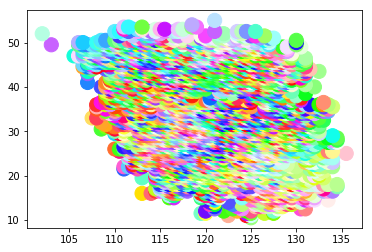

In [13]:
fig, ax = plt.subplots()
ax.scatter(lons, lats, s=200, facecolors=cgpp)
plt.show()

In [14]:
lons

array([125. , 122.5, 124.5, ..., 119. , 118.5, 121. ])

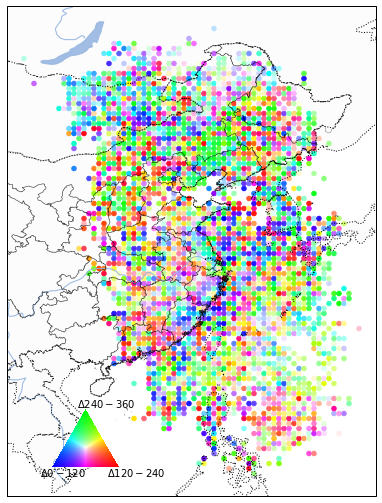

In [15]:
regfig(lats,lons,cgpp,z_min=-1.,z_max=1.,figname="ccn_yrd",units=None,title="")

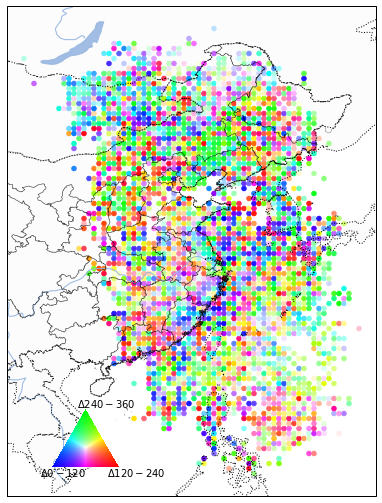

In [16]:
regfig(lats,lons,cgpp,z_min=-1.,z_max=1.,figname="ccn_yrd",units=None,title="")

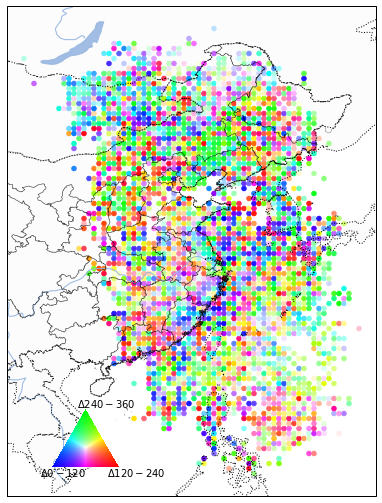

In [17]:
regfig(lats,lons,cgpp,z_min=-1.,z_max=1.,figname="ccn_yrd11",units=None,title="")

# reference

maskout http://bbs.06climate.com/forum.php?mod=viewthread&tid=89530

smooth https://stackoverflow.com/questions/14765891/image-smoothing-in-python
平滑以后值就会变
matplotlib 3D scatterplot with marker color corresponding to RGB values